# 8.2. Redes usando blocos (VGG)

A ideia de usar blocos surgiu primeiramente do Visual Geometry Group (VGG) da Universidade de Oxford, em sua rede homônima VGG ( Simonyan e Zisserman, 2014 ) 

AlexNet não forneceu um modelo geral para orientar pesquisadores subsequentes no design de novas redes.
Nas seções a seguir, apresentaremos vários conceitos heurísticos comumente usados ​​para projetar redes profundas.

O design de arquiteturas de redes neurais tornou-se progressivamente mais abstrato, com pesquisadores passando de pensar em termos de neurônios individuais para camadas inteiras e agora para blocos, repetindo padrões de camadas. Uma década depois, isso progrediu para pesquisadores usando modelos inteiros treinados para reutilizá-los para tarefas diferentes, embora relacionadas. Esses grandes modelos pré-treinados são normalmente chamados de modelos de fundação ( Bommasani et al. , 2021 ) .

# 8.2.1. Blocos VGG

O bloco de construção básico das CNNs é uma sequência do seguinte: 

- (i) uma camada convolucional (LazyConv2D/Conv2D) com preenchimento (padding) para manter a resolução, 
- (ii) uma não linearidade (ReLU), 
- (iii) uma camada de pooling (MaxPool2D) para reduzir a resolução.

Um dos problemas com essa abordagem é que a resolução espacial diminui muito rapidamente.

__De volta ao VGG: um bloco VGG consiste em uma sequência de convoluções com 3x3 kernels com preenchimento de 1 (mantendo altura e largura) seguido por uma camada max-pooling com passo de 2 (reduzindo pela metade a altura e a largura após cada bloco). No código abaixo, definimos uma função chamada vgg_block para implementar um bloco VGG.__

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):    # Diversos Conv/ReLU seguido por MaxPool2d
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

# 8.2.2. Rede VGG

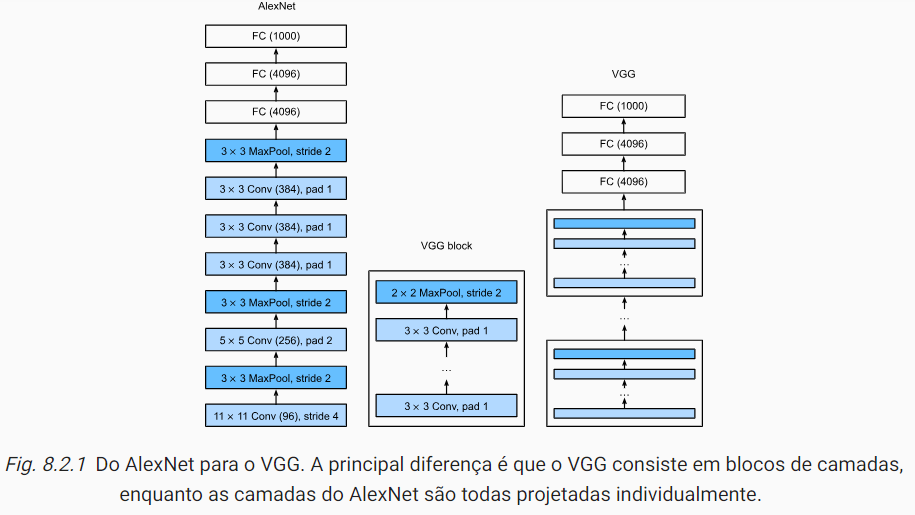

Esse agrupamento de convoluções é um padrão que permaneceu quase inalterado na última década, embora a escolha específica de operações tenha sofrido modificações consideráveis.

A variável arch consiste em uma lista de tuplas (uma por bloco), onde cada uma contém dois valores: o número de camadas convolucionais e o número de canais de saída, que são precisamente os argumentos necessários para chamar a vgg_block função.

In [3]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

A rede VGG original tinha cinco blocos convolucionais, entre os quais os dois primeiros têm uma camada convolucional cada e os últimos três contêm duas camadas convolucionais cada. O primeiro bloco tem 64 canais de saída e cada bloco subsequente dobra o número de canais de saída, até que esse número atinja 512. Como essa rede usa oito camadas convolucionais e três camadas totalmente conectadas, ela é frequentemente chamada de VGG-11.

In [4]:
# arch consiste em uma lista de tuplas (uma por bloco), onde cada uma contém dois valores: 
#o número de camadas convolucionais e o número de canais de saída, que são precisamente os argumentos necessários para chamar a vgg_block função.
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary((1, 1, 224, 224))  # Sumário para entrada de shape (1, 1, 224, 224)

C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


Como você pode ver, reduzimos pela metade a altura e a largura em cada bloco, finalmente atingindo uma altura e largura de 7 antes de achatar as representações para processamento pela parte totalmente conectada da rede. 

# 8.2.3. Treinamento

Como o VGG-11 é computacionalmente mais exigente do que o AlexNet, construímos uma rede com um número menor de canais. Isso é mais do que suficiente para o treinamento no Fashion-MNIST.

In [16]:
VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))).layer_summary((1, 1, 224, 224))  # Sumário para entrada de shape (1, 1, 224, 224)
# VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))).layer_summary((1, 1, 112, 112))  # Sumário para entrada de shape (1, 1, 224, 224)
# VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary((1, 1, 224, 224))  # Sumário para entrada de shape (1, 1, 224, 224)

Sequential output shape:	 torch.Size([1, 16, 56, 56])
Sequential output shape:	 torch.Size([1, 32, 28, 28])
Sequential output shape:	 torch.Size([1, 64, 14, 14])
Sequential output shape:	 torch.Size([1, 128, 7, 7])
Sequential output shape:	 torch.Size([1, 128, 3, 3])
Flatten output shape:	 torch.Size([1, 1152])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [7]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
# trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)    # aplica a função init_cnn, que realiza a inicialização Xavier
# trainer.fit(model, data)

https://colab.research.google.com/drive/11zd8Wwbw7rFvVBvb1NlsoCgFW1xnxpWq#scrollTo=lPHU9nN6qrws

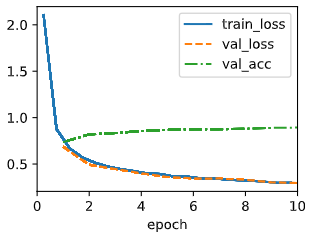

In [ ]:
# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
torch.save(model.state_dict(), '/content/drive/My Drive/VGG.params')                    # salva todos os parâmetros do modelo treinado.
 #  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros



In [8]:

# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
clone.load_state_dict(torch.load('VGG.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


VGG(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride

In [10]:
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


# arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))
# model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)


vgg = VGG(arch=arch)
X = torch.randn(1,3, 224, 224)
_ = vgg(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(vgg.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = vgg.to(device)

summary(vgg, (3, 224, 224))
params


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
             ReLU-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 128,

{'conv': 577120, 'lr': 42516490}

In [17]:
# SUMÁRIO DETALHADO: size(112,112)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


# arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))
# model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)


vgg = VGG(arch=arch)
X = torch.randn(1,3, 112, 112)
_ = vgg(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(vgg.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = vgg.to(device)

summary(vgg, (3, 112, 112))
params


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
              ReLU-2         [-1, 16, 112, 112]               0
         MaxPool2d-3           [-1, 16, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]           4,640
              ReLU-5           [-1, 32, 56, 56]               0
         MaxPool2d-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          36,928
             ReLU-10           [-1, 64, 28, 28]               0
        MaxPool2d-11           [-1, 64, 14, 14]               0
           Conv2d-12          [-1, 128, 14, 14]          73,856
             ReLU-13          [-1, 128, 14, 14]               0
           Conv2d-14          [-1, 128,

{'conv': 577120, 'lr': 21544970}

# 8.2.4. Resumo

Pode-se argumentar que o VGG é a primeira rede neural convolucional verdadeiramente moderna. Enquanto o AlexNet introduziu muitos dos componentes do que torna o aprendizado profundo eficaz em escala, é o VGG que, sem dúvida, introduziu propriedades-chave, como blocos de múltiplas convoluções e uma preferência por redes profundas e estreitas. É também a primeira rede que é, na verdade, uma família inteira de modelos parametrizados de forma semelhante, dando ao praticante ampla compensação entre complexidade e velocidade. Este é também o lugar onde as estruturas modernas de aprendizado profundo brilham. Não é mais necessário gerar arquivos de configuração XML para especificar uma rede, mas sim montar essas redes por meio de código Python simples.


# Código Agrupado

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# ------------------------------------------------------------------------------------
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):    # Diversos Conv/ReLU seguido por MaxPool2d
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)


# arch consiste em uma lista de tuplas (uma por bloco), onde cada uma contém dois valores:
#o número de camadas convolucionais e o número de canais de saída, que são precisamente os argumentos necessários para chamar a vgg_block função.

model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
# trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)    # aplica a função init_cnn, que realiza a inicialização Xavier
trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
torch.save(model.state_dict(), '/content/drive/My Drive/VGG16.params')                    # salva todos os parâmetros do modelo treinado.
 #  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros

# -----------------------------------------------------------------------------------------------------
# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
clone.load_state_dict(torch.load('VGG.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------

# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


# arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))
# model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)


vgg = VGG(arch=arch)
X = torch.randn(1,3, 224, 224)
_ = vgg(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(vgg.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = vgg.to(device)

summary(vgg, (3, 224, 224))
params

# -----------------------------------------------------------------------------------------------------


# Exercícios:

# Ex. 3 - Use a Tabela 1 no artigo VGG ( Simonyan e Zisserman, 2014 ) para construir outros modelos comuns, como VGG-16 ou VGG-19.

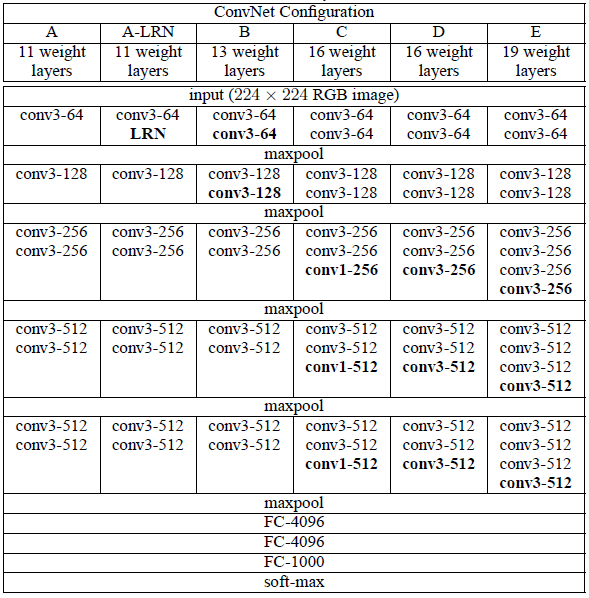
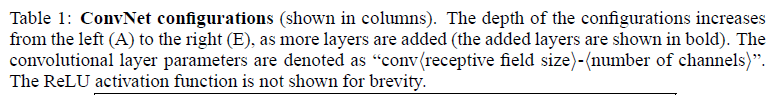

Resposta:

VGG-16:

https://colab.research.google.com/drive/1BUJceEmBDL-zltl1ZG280WvHoT2zNlyt#scrollTo=nsvN0IOod35u

Artigo:

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1409.1556

# Ex. 4 - Aumentando a resolução no Fashion-MNIST em oito vezes a partir de 28x28 para 224x224 dimensões é muito desperdício. Tente modificar a arquitetura da rede e a conversão de resolução, por exemplo, para 56 ou 84 dimensões para sua entrada. Você pode fazer isso sem reduzir a precisão da rede? Consulte o artigo VGG ( Simonyan e Zisserman, 2014 ) para obter ideias sobre como adicionar mais não linearidades antes da redução da amostragem.



Resposta:

https://colab.research.google.com/drive/10BkVWIKlbRemyi7HWRD4gDaRZNSMSSr4#scrollTo=boYoTY5UdwSw

# Outras respostas:

https://pandalab.me/archives/vgg